In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# #######################################
# ### Generic gradient checker
# def generic_gradient_checker(X, y, theta, objective_func, gradient_func, 
#                              epsilon=0.01, tolerance=1e-4):
#     """
#     The functions takes objective_func and gradient_func as parameters. 
#     And check whether gradient_func(X, y, theta) returned the true 
#     gradient for objective_func(X, y, theta).
#     Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
#     """
#     #TODO

def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)
    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test

### Problem 4

In [3]:
#######################################
### Feature normalization
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    #Initialize return variables
    train_normalized, test_normalized = [] , []
    #Iterate over 2D array 
    for d in range(train.shape[1]):
        #Grab subsets
        train_temp = train[:,d]
        test_temp = test[:,d]
        train_min = train_temp.min()
        train_max = train_temp.max()
        #If the column is not filled with constants, we want to include them
        if len(np.unique(train_temp)) > 1:
            #Grab the columns, transform, and append to list (implicitly making them rows)
            train_normalized.append((train_temp - train_min) / (train_max - train_min))
            test_normalized.append((test_temp - train_min) / (train_max - train_min))
            
    #Reformat data type to np.array and Transpose so rows become columns
    train_normalized, test_normalized = np.array(train_normalized).T, np.array(test_normalized).T  
    #Return values
    return train_normalized, test_normalized

In [4]:
x_train, y_train, x_test, y_test = load_data()

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


### Problem 8

In [5]:
#######################################
### The square loss function
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    #Count number of rows
    n = X.shape[0]
    #Calculate y hat
    y_hat = X @ theta
    #Calculate sum of squares
    sum_of_squares = sum((y_hat - y)**2)
    #Return our calculated loss
    loss = sum_of_squares/n
    return loss

### Problem 9

In [6]:
#######################################
### The gradient of the square loss function
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    #Calculate number of observations
    m = X.shape[0]
    #Calculate gradient using closed form solution from problem 6
    gradient = ((X.T @ X @ theta) - (X.T @ y)) * 2/m
    #Return gradient
    return gradient

In [7]:
compute_square_loss_gradient(x_train, y_train, np.random.rand(x_train.shape[1]))

array([22.73131311, 22.12803126, 21.50621043, 21.15094816, 20.89705985,
       20.465192  , 19.65398635, 19.65398635, 18.67988746, 17.02526657,
       15.5707931 , 14.81789844, 12.56434133, 10.8761827 ,  6.73585579,
        5.92556579,  4.17655825,  0.73183347, 19.94527049, 19.94527049,
       19.94527049, 18.46507502, 18.46507502, 18.46507502, 17.07879583,
       17.07879583, 17.07879583, 16.43568024, 16.43568024, 16.43568024,
       16.07860351, 16.07860351, 16.07860351, 10.08809468, 10.08809468,
       10.08809468, 12.27488263, 12.27488263, 12.27488263, 13.53540838,
       13.53540838, 13.53540838, 14.10817529, 14.10817529, 14.10817529,
       14.42257155, 14.42257155, 14.42257155, 22.91995948])

### Problem 10

In [8]:
#######################################
### Gradient checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm. Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    ### Given Code:
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
  
    ### My Code:
    #Generate helper variable, a vector filled with epsilons
    epsilon_vec = np.array([epsilon]*num_features)
    
    #Iterate d times, where d is the number of features
    for i in range(num_features):
        #Generate array of 0s
        e_i = np.zeros(num_features) 
        #Set the ith entry to 1
        e_i[i] = 1 
        #Compute Partial Derivative for ith entry
        partial = (compute_square_loss(X,y,theta+(e_i * epsilon)) - (compute_square_loss(X,y,theta-(e_i * epsilon)) )) / (2 * epsilon)
        #Write to our approx_grad array
        approx_grad[i] = partial
    #Calculate the Euclidean Norm of the difference in gradients
    difference = (sum((approx_grad - true_gradient)**2)) ** .5
    #Check if our approximation exceeded the tolerance level
    if difference > tolerance:
        return False #If the difference exceeds tolerance, return False
    else:
        return True #Otherwise our gradient works well, return True

In [9]:
grad_checker(x_train, y_train,np.random.rand(x_train.shape[1]))

True

### Problem 11

In [10]:
#######################################
### Batch gradient descent
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    ### Given Code:
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.zeros(num_features)  #Initialize theta
    ### My Code:
    #theta = np.random.rand(num_features)
    #Iterate over gradient descent steps
    for i in range(0,num_step+1):
        #Write theta
        theta_hist[i,:] = theta
        #Compute Gradient and Calculate and Append Loss
        gradient = compute_square_loss_gradient(X,y,theta)
        loss_hist[i] = compute_square_loss(X,y,theta)
        #Calculate and write new theta
        theta = theta - (alpha * gradient)
    #Return theta_hist, loss_hist    
    return theta_hist, loss_hist

### Problem 12
Now let's experiment with the step size. Note that if the step size
is too large, gradient descent may not converge. Starting with a step-size of $0.1$, try various different fixed
step sizes to see which converges most quickly and/or which diverge.
As a minimum, try step sizes 0.5, 0.1, .05, and .01. Plot the average square loss on the training set as a function of the number of steps for
each step size. Briefly summarize your findings. 

In [11]:
alphas = [.05,.01,.1,.5]
alpha_theta_hist_dict, alpha_loss_hist_dict = {}, {}
for a in alphas:
    alpha_theta_hist_dict[a] = []
    alpha_loss_hist_dict[a] = []

for a in alphas:
    alpha_theta_hist_dict[a], alpha_loss_hist_dict[a] = batch_grad_descent(x_train,y_train, alpha=a)

Text(0.5, 1.0, 'Average Training Error For Various Alpha Step Size')

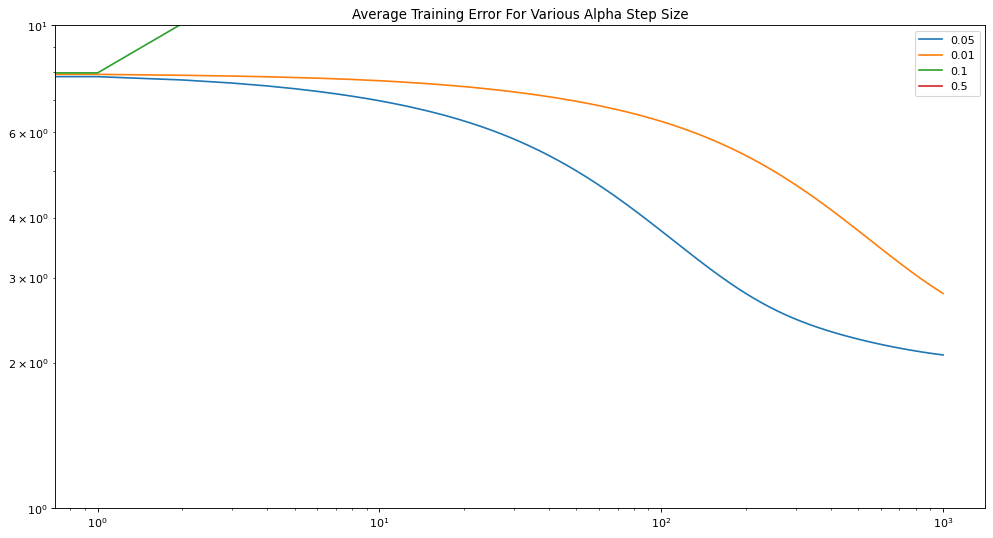

In [12]:
#Generate helper variable for x-axis
x = list(range(1001))
#Begin plotting
plt.figure(figsize=(15, 8), dpi=80)
for alpha in alphas:
    plt.plot(x,alpha_loss_hist_dict[alpha], label=alpha)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title("Average Training Error For Various Alpha Step Size")

### It appears that step sizes .5 and .01 diverge to infinity, while step sizes .05 and .01 converge to ~2 and ~2.7 respectively.

### Problem 13

In [13]:
###Using step size alpha = .05 calculate average test loss as a functio of N iterations

#Initialize helper variables
N = 1000
average_test_loss = np.zeros(N)

#Iterate over 1000 steps
for step in range(N):
    #Calculate average test loss
    average_test_loss[step] = compute_square_loss(x_test,y_test, alpha_theta_hist_dict[.05][step])

Text(0.5, 1.0, 'Average Test Loss, Step Size Alpha = .01, Theta as a function of N ')

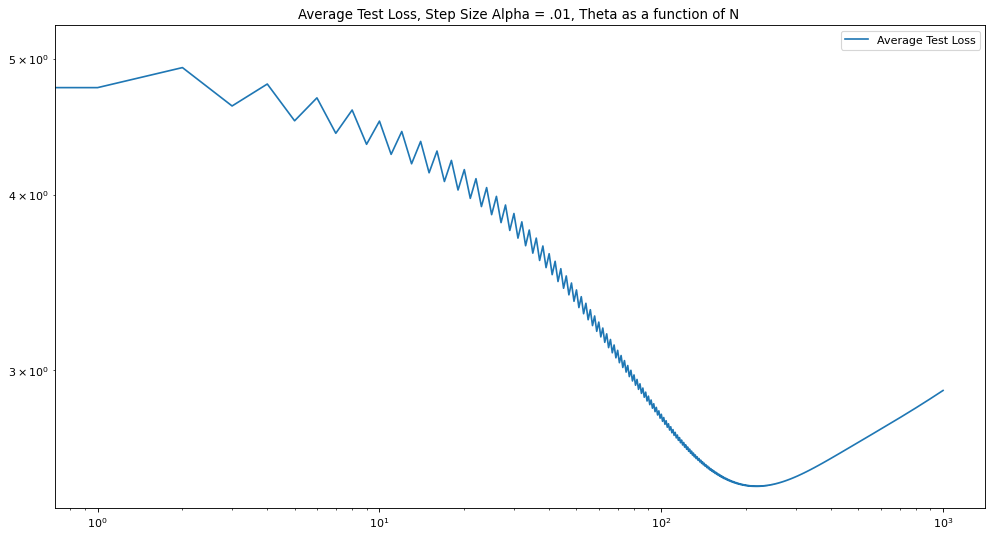

In [14]:
#Generate helper variable for x-axis
x = list(range(1000))
#Begin plotting
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(x,average_test_loss, label='Average Test Loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title("Average Test Loss, Step Size Alpha = .01, Theta as a function of N ")

### Question 15

In [15]:
#######################################
### The gradient of regularized batch gradient descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    #Calculate number of observations
    m = X.shape[0]
    #Calculate gradient using closed form solution from problem 14
    grad = (((X.T @ X @ theta) - (X.T @ y)) * 2/m) + (2*lambda_reg*theta)
    #Return gradient
    return grad

### Question 16

In [16]:
#######################################
### Regularized batch gradient descent
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    #TODO
    #Iterate over gradient descent steps
    for i in range(0,num_step+1):
        #Write theta
        theta_hist[i,:] = theta
        #Compute Gradient and Calculate and Append Loss
        loss_hist[i] = compute_square_loss(X,y,theta)
        #Calculate gradient
        gradient = compute_regularized_square_loss_gradient(X,y,theta,lambda_reg)
        #Calculate and write new theta
        theta = theta - (alpha * gradient)
    #Return theta_hist, loss_hist    
    return theta_hist, loss_hist

### Question 17

Text(0.5, 1.0, 'Average Training Error For Ridge Regression Various Lambda Size')

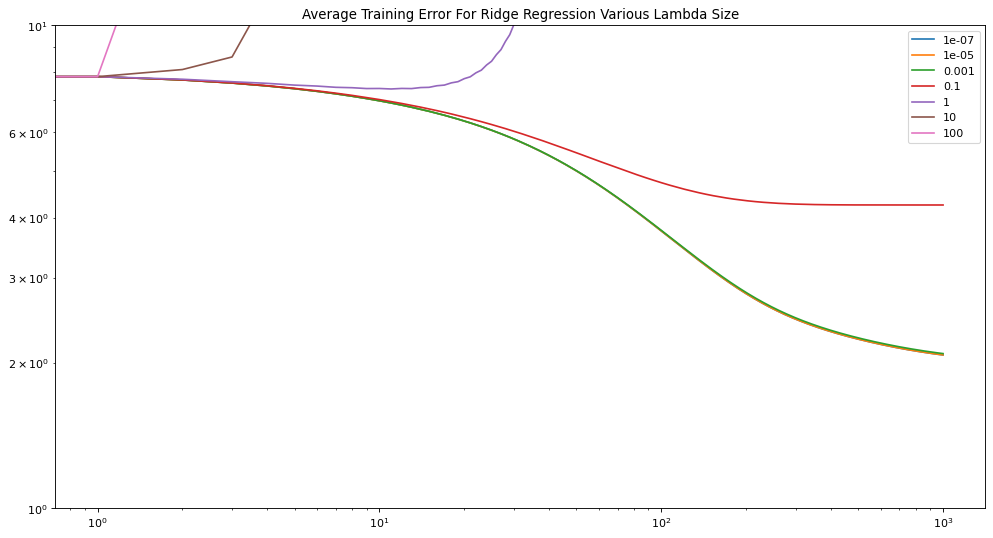

In [17]:
#Define helper variables
lambdas = [10**-7, 10**-5, 10**-3, 10**-1,1, 10,100]
step_size = .05
train_loss_dict = {}
hist_theta_dict = {}
test_loss_dict = {}
hist_theta_dict = {}
#Iterate over lambdas
for l in lambdas:
     hist_theta_dict[l], train_loss_dict[l] = regularized_grad_descent(x_train,y_train,alpha=step_size, lambda_reg=l,num_step=1000)
#Generate helper variable for x-axis
x = list(range(1001))
#Begin plotting
plt.figure(figsize=(15, 8), dpi=80)
for l in lambdas:
    plt.plot(x,train_loss_dict[l], label=''.join(str(l)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title("Average Training Error For Ridge Regression Various Lambda Size")

Text(0.5, 1.0, 'Average Testing Error For Ridge Regression Various Lambda Size as a function of N')

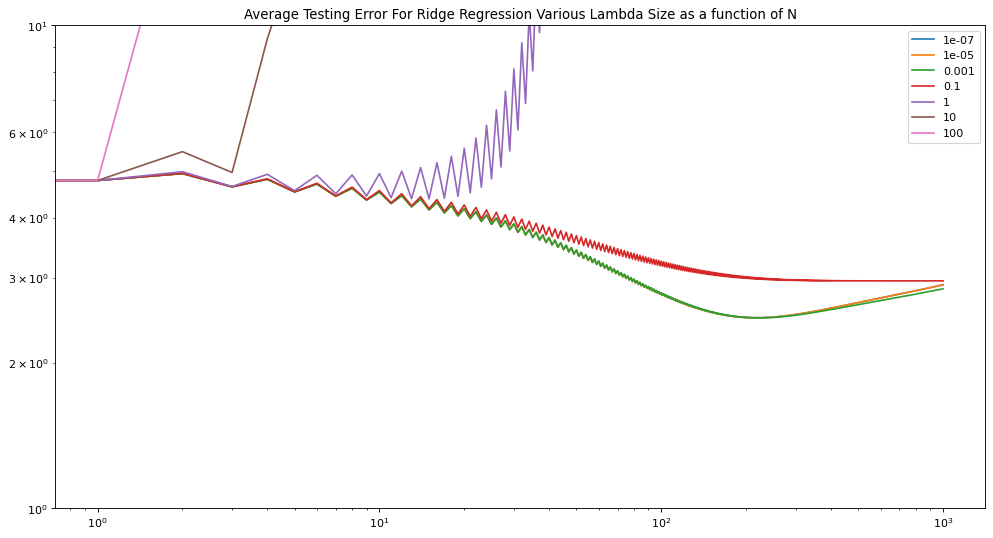

In [18]:
###Using step size alpha = .05 calculate average test loss as a functio of N iterations

#Initialize helper variables
N = 1001
average_test_loss = {}
for l in lambdas:
    average_test_loss[l] = []
#Iterate over 1000 steps
for l in lambdas:
    for step in range(N):
        #Calculate average test loss
        average_test_loss[l].append(compute_square_loss(x_test,y_test,hist_theta_dict[l][step]))
    average_test_loss[l] = np.array(average_test_loss[l]) #Make np array
#Generate helper variable for x-axis
x = list(range(1001))
#Begin plotting
plt.figure(figsize=(15, 8), dpi=80)
for l in lambdas:
    plt.plot(x,average_test_loss[l], label=''.join(str(l)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title("Average Testing Error For Ridge Regression Various Lambda Size as a function of N")

## While some lambdas diverge, other lambdas such as $L\in [10^{-7},10^{-5},10^{-3},10^{-1}]$ begin to reduce testing error and show the benefeits of regularization, as our model begins generalizing better and better to the testing data. This is not without fault: as for all of the lines that performed better begin to overfit the data as the step size increases above 200. This is clearly illustrated on the graph above as the curved lines change from sloping downwards to upwards.

### Question 18

 When $\lambda = 10^{-3}$ the testing error is reduced as much as possible at 2.84, while still having great training error only .014 more than the minimum training error.

In [19]:
for l in lambdas:
    print('Lambda = ', l, 'Avg Train Loss ', train_loss_dict[l][-1], 'Avg Test Loss ', average_test_loss[l][-1])

Lambda =  1e-07 Avg Train Loss  2.077700614426301 Avg Test Loss  2.9034175759537235
Lambda =  1e-05 Avg Train Loss  2.0778239254952293 Avg Test Loss  2.902834530224271
Lambda =  0.001 Avg Train Loss  2.0913500007595984 Avg Test Loss  2.847542512245568
Lambda =  0.1 Avg Train Loss  4.245811582850459 Avg Test Loss  2.957710971076267
Lambda =  1 Avg Train Loss  2.4907665006408443e+64 Avg Test Loss  2.105795019591247e+64
Lambda =  10 Avg Train Loss  inf Avg Test Loss  inf
Lambda =  100 Avg Train Loss  nan Avg Test Loss  nan


Text(0.5, 1.0, 'Average Test Loss For Last Step Ridge Regression Various Lambda Size')

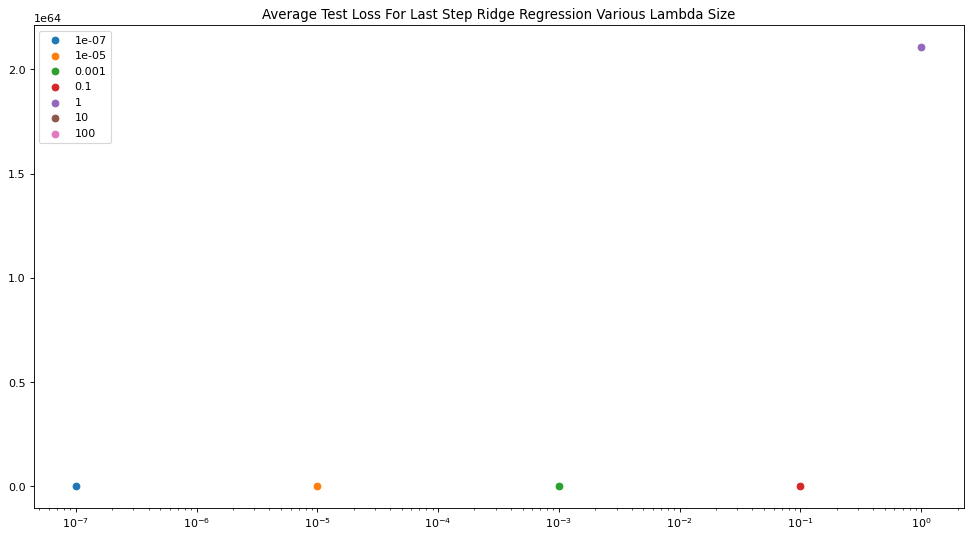

In [20]:
#Begin plotting
plt.figure(figsize=(15, 8), dpi=80)
for l in lambdas:
    plt.scatter(l,average_test_loss[l][-1], label=''.join(str(l)))
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title("Average Test Loss For Last Step Ridge Regression Various Lambda Size")

### Question 19

I would still pick $\lambda = 10^{-3}$ as it minimizes both train and test loss the most effectively.

In [21]:
for l in lambdas:
    print('Lambda = ', l, 'Min Train Loss ', min((train_loss_dict[l])), 'Min Test Loss ', min(average_test_loss[l]))

Lambda =  1e-07 Min Train Loss  2.077700614426301 Min Test Loss  2.4799523634844363
Lambda =  1e-05 Min Train Loss  2.0778239254952293 Min Test Loss  2.4799379219810977
Lambda =  0.001 Min Train Loss  2.0913500007595984 Min Test Loss  2.4784998174321498
Lambda =  0.1 Min Train Loss  4.245811582850459 Min Test Loss  2.9576980675377906
Lambda =  1 Min Train Loss  7.380047560534102 Min Test Loss  4.371101634599719
Lambda =  10 Min Train Loss  7.826519529702243 Min Test Loss  4.7714933968428515
Lambda =  100 Min Train Loss  7.826519529702243 Min Test Loss  4.7714933968428515


Text(0.5, 1.0, 'Min Train Loss For Last Step Ridge Regression Various Lambda Size')

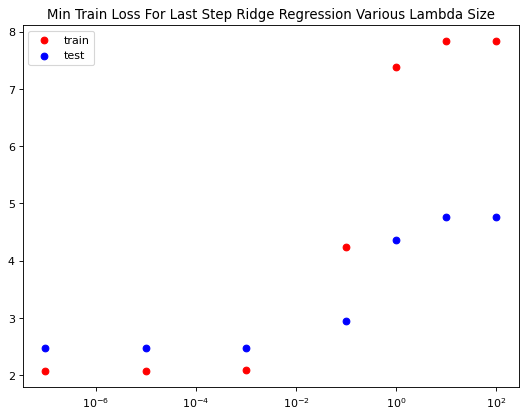

In [22]:
#Begin plotting
plt.figure(figsize=(8, 6), dpi=80)
for l in lambdas:
    plt.scatter(l,min(train_loss_dict[l]),label='Train',color='r')
    plt.scatter(l,min(average_test_loss[l]), label='Test',color='b')
#plt.yscale('log')
plt.xscale('log')
plt.legend(labels=['train','test'])
plt.title("Min Train Loss For Last Step Ridge Regression Various Lambda Size")

Lambda =  1e-07 Avg Train Loss  2.077700614426301 Avg Test Loss  2.9034175759537235
Lambda =  1e-05 Avg Train Loss  2.0778239254952293 Avg Test Loss  2.902834530224271
Lambda =  0.001 Avg Train Loss  2.0913500007595984 Avg Test Loss  2.847542512245568
Lambda =  0.1 Avg Train Loss  4.245811582850459 Avg Test Loss  2.957710971076267
Lambda =  1 Avg Train Loss  2.4907665006408443e+64 Avg Test Loss  2.105795019591247e+64
Lambda =  10 Avg Train Loss  inf Avg Test Loss  inf
Lambda =  100 Avg Train Loss  nan Avg Test Loss  nan


Text(0.5, 1.0, 'Average Train Loss For Last Step Ridge Regression Various Lambda Size, with Min Train and Test Error')

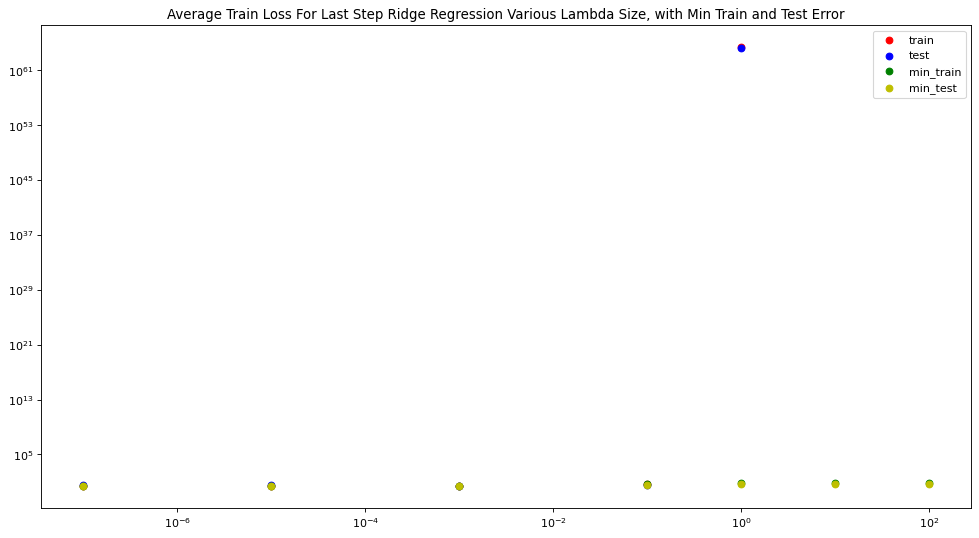

In [23]:
#Begin plotting
plt.figure(figsize=(15, 8), dpi=80)
for l in lambdas:
    plt.scatter(l,train_loss_dict[l][-1], color='r')
    plt.scatter(l,average_test_loss[l][-1], color='b')
    plt.scatter(l,min(train_loss_dict[l]),color='g')
    plt.scatter(l,min(average_test_loss[l]), color='y')
    print('Lambda = ', l, 'Avg Train Loss ', train_loss_dict[l][-1], 'Avg Test Loss ', average_test_loss[l][-1])
    #print('Lambda = ', l, 'Min Train Loss ', min((train_loss_dict[l])), 'Min Test Loss ', min(average_test_loss[l]))
plt.yscale('log')
plt.xscale('log')
plt.legend(labels=['train','test','min_train','min_test'])
plt.title("Average Train Loss For Last Step Ridge Regression Various Lambda Size, with Min Train and Test Error")

### Question 24

In [24]:
#######################################
### Stochastic gradient descent
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss_hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    #TODO
    
    #Save helper variable
    m = X.shape[0]

    t=1
    #Iterate over the number of epochs
    for epoch in range(num_epoch):
        
        #Shuffle the data so we can sample randomly
        randomized_data = np.random.permutation(num_instances)
        for step in range(len(randomized_data)):
            
            #Append thetas and loss
            theta_hist[epoch,step] = theta
            loss_hist[epoch,step] = compute_square_loss(X,y,theta) + lambda_reg*(theta.T@theta)
            
            #Helper variable
            index = randomized_data[step]
            X_temp = np.array(X[index]).reshape((1,49))
            y_temp = np.array(y[index]).reshape((1,1))
            theta = theta.reshape((49,1))
            gradient = (2*((X_temp.T@X_temp@theta) - (X_temp.T@y_temp)))+(2*lambda_reg*theta)
            gradient, theta = gradient.reshape((49,)), theta.reshape((49,))
            
            #Check for alpha value
            if alpha == "1/sqrt(t)":
                #1/sqrt(t) step size
                theta = theta - (gradient * (.1/np.sqrt(t)))
                t += 1
            elif alpha == "1/t":
                #1/t step size
                theta = theta - (gradient * (.1/t))
                t += 1
            else:
                #Fixed step size
                theta = theta - (gradient * alpha)

    #Return values
    return theta_hist, loss_hist

### Question 25

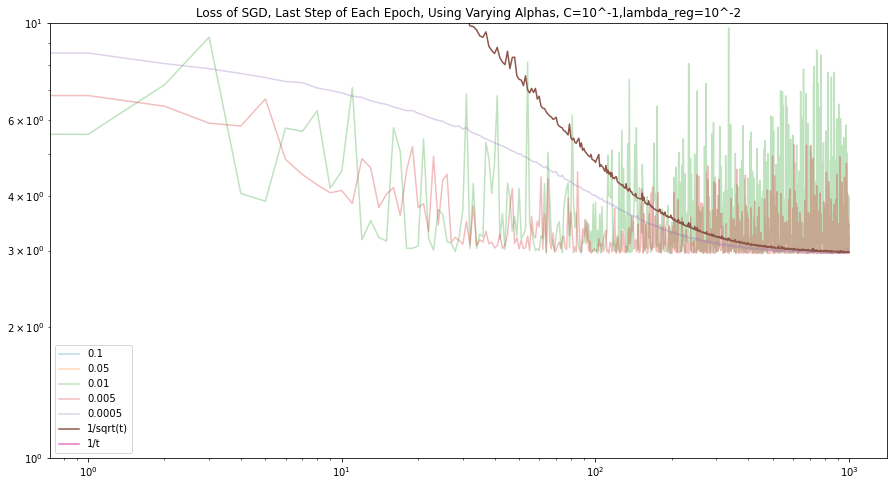

In [25]:
#Initialize helper variables
lam = 10**-2
alphas = [.1,.05,.01,.005,.0005,'1/sqrt(t)','1/t']
loss_dict = {}
theta_dict = {}
for alpha in alphas:
    loss_dict[alpha] = []
    theta_dict[alpha] = []
#Caclulate Thetas and Loss Dictionaries
for a in alphas:
    theta_dict[a], loss_dict[a] = stochastic_grad_descent(x_train,y_train,alpha=a,lambda_reg = lam)

#Plot loss
plt.figure(figsize=(15,8))
for a in alphas:
    if type(a)==float:
        plt.plot(x[:-1],loss_dict[a][:,-1], label=a, alpha=.3)
    else:
        plt.plot(x[:-1],loss_dict[a][:,-1], label=a)
plt.xscale('log')
plt.yscale('log')
plt.title('Loss of SGD, Last Step of Each Epoch, Using Varying Alphas, C=10^-1,lambda_reg=10^-2')
plt.legend()
plt.show()

### Results Analysis:
As expected, for the static step sizes most diverged, while other estimates were noisey and bounced around the minimum. The function that performed the best (as in was the smoothest) was the dynamic step size of $\frac{C}{\sqrt{t}}$, with $C=.1$. This function converged to the local minimum slower, but in much smoother fashion. This is due to the dynamic step size which dampens the noise and lets SGD avoid bouncing around the local or global minimum, and allows for easier convergence to said minimum. That being said, a static really small step size, in this case $\alpha = .005$, also performed very well, reaching the minimum faster than the dynamic step size while not bouncing around the minimum like its larger static step size peers.

In [26]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test


def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]



X_train, X_test, y_train, y_test = pre_process_mnist_01()

clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)

# test = classification_error(clf, X_test, y_test)
# train = classification_error(clf, X_train, y_train)
# print('train: ', train, end='\t')
# print('test: ', test)

-- Epoch 1
Norm: 0.69, NNZs: 289, Bias: 0.003645, T: 9902, Avg. loss: 0.041850
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 0.78, NNZs: 258, Bias: 0.003422, T: 19804, Avg. loss: 0.031808
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 241, Bias: 0.003509, T: 29706, Avg. loss: 0.030258
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 0.89, NNZs: 233, Bias: 0.003690, T: 39608, Avg. loss: 0.029196
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 0.92, NNZs: 227, Bias: 0.003947, T: 49510, Avg. loss: 0.028678
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 0.96, NNZs: 219, Bias: 0.004242, T: 59412, Avg. loss: 0.028280
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 0.99, NNZs: 214, Bias: 0.004562, T: 69314, Avg. loss: 0.027930
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 1.01, NNZs: 212, Bias: 0.004903, T: 79216, Avg. loss: 0.027672
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 1.04, NNZs: 208, Bias: 0.005261, T: 89118, Avg. loss: 0.027464
T

SGDClassifier(alpha=0.01, eta0=0.01, learning_rate='invscaling', loss='log',
              penalty='l1', verbose=1)

### Problem 28

In [27]:
def classification_error(clf, X, y):
    """
    Input:
    clf: (object) trained classifier model
    X: (np.array) design matrix
    y: (np.array) target values
    
    Output:
    error: (float) Classification Error
    """
    two_n = 2*len(y)
    summed_error = sum(abs(clf.predict(X)-y))
    error = summed_error / two_n
    return error

In [28]:
print("Classiciation Error:",classification_error(clf, X_test,y_test))

Classiciation Error: 0.001025010250102501


### Problem 29

In [29]:
def create_error_by_alpha (X_train, y_train, X_test, y_test, alpha_array, repeat_times):
    
    #errArray = np.zeros(len(alpha_array)*repeat_times)
    average_arr, std_arr, coeffs_arr = [], [], []
    
    #Iterate over alpha_array
    for j in range(len(alpha_array)):
        
        #Create temporary Helper variable
        temp_arr = np.zeros(repeat_times)
        
        #Initialize classifier
        clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=alpha_array[j], 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=0)
        #Iterate for how over many times
        for i in range(repeat_times):
            #Select subsample with 100 points
            x_train, y_train = sub_sample(100, X_train, y_train)
            #Fit model
            clf.fit(x_train, y_train)
            #Get classification error
            temp_arr[i]=classification_error(clf, X_test, y_test)
            #Edge cases where i == 0
            if i ==0:
                coeffs_arr.append(clf.coef_)
        #Calculate mean, std, and append
        average, std = np.mean(temp_arr), np.std(temp_arr)
        #Append
        average_arr.append(average)
        std_arr.append(std)
    #Return the means and standard deviations    
    return average_arr, std_arr, np.array(coeffs_arr)

Text(0.5, 1.0, 'Mean Test Error with 1 Std of Error Bars, For Various Alphas')

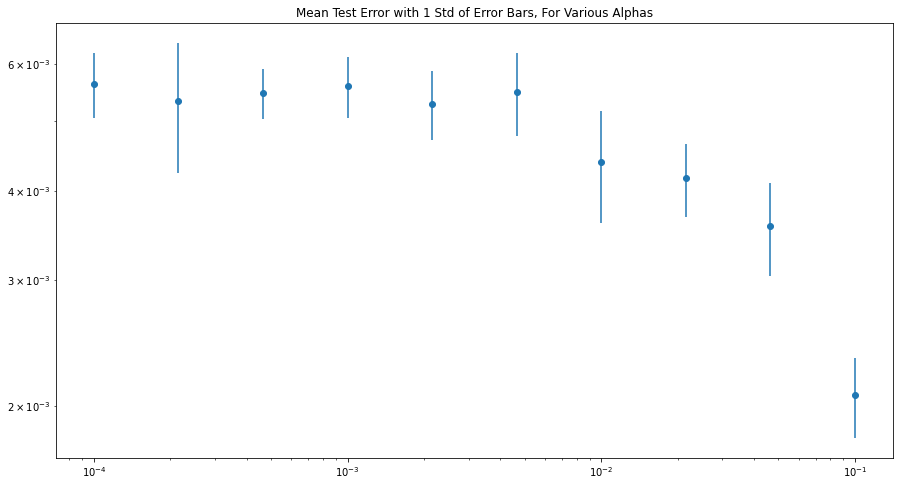

In [30]:
#Set up optimal Spacing
alpha_array = np.logspace(-4,-1, num =10)
#Create subsamples and calculate average, std, coeffs
average_arr, std_arr, coeffs_arr = create_error_by_alpha(X_train, y_train, X_test, y_test,alpha_array,10)
#Plot the figure
plt.figure(figsize = (15,8))
plt.errorbar(alpha_array,average_arr,yerr = std_arr, fmt = 'o')
plt.yscale("log")
plt.xscale('log')
plt.title("Mean Test Error with 1 Std of Error Bars, For Various Alphas")

In [31]:
#Initialize helper variable
output_arr = []
#Iterate over the alpha values used for regularization
for alpha in range(coeffs_arr.shape[0]):
    #Reshape the array to 28x28 pixels
    reshaped_array = coeffs_arr[alpha][0].reshape(28,28)
    #Append reshaped array
    output_arr.append(reshaped_array)
    #Print alpha and L1 Norm Values
    print("For Alpha ",alpha_array[alpha]," the L1 norm is: ", sum(abs(coeffs_arr[alpha][0])))  

For Alpha  0.0001  the L1 norm is:  8.089057040139913
For Alpha  0.00021544346900318845  the L1 norm is:  8.077843494873163
For Alpha  0.00046415888336127773  the L1 norm is:  7.917882542767075
For Alpha  0.001  the L1 norm is:  7.9837497213638065
For Alpha  0.002154434690031882  the L1 norm is:  7.709855371253047
For Alpha  0.004641588833612777  the L1 norm is:  7.0872641049912035
For Alpha  0.01  the L1 norm is:  6.19616177542646
For Alpha  0.021544346900318822  the L1 norm is:  5.089043082646317
For Alpha  0.046415888336127774  the L1 norm is:  3.5123758485032095
For Alpha  0.1  the L1 norm is:  2.1586612335879334


### Problem 30

Since we repeated this experiment many times, and thus sampled many times, the main source of randomness we averaged over and eliminated was the randomness inherente in our method of selecting train and testing data. 

### Problem 31

#### The optimal value for alpha was the one that lowered the testing error the most, which in our case was when $\alpha=10^{-1}$.

### Problem 32

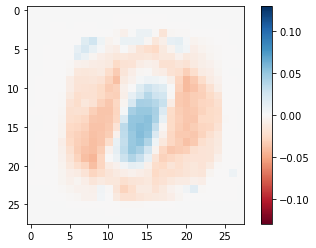

In [32]:
#Plot the heat map for the first iteration (Least Regularization)
scale = np.abs(clf.coef_).max()
plt.imshow(output_arr[0], cmap=plt.cm.RdBu, vmax=scale, vmin=-scale )
plt.colorbar()
plt.show()

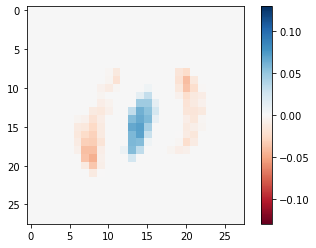

In [33]:
#Plot the heat map for the last iteration (Most Regularization)
plt.imshow(output_arr[-1], cmap=plt.cm.RdBu, vmax=scale, vmin=-scale )
plt.colorbar()
plt.show()

### Problem 33

There is definitely a pattern occuring in $\theta$. As we increase our regularization parameter, $\alpha$, since we use the L1 norm, more and more coefficients get zeroed out, hence the large amount of gray values present in the heat maps above. Those gray values do not provide any information or predictive value on whether or not our $28 \times 28$ image of pixels is a 1 or a 0. In a very interesting and cool fashion, the coefficients in $\theta$ that have the smallest value, (the largest absolute value for a negative number), form a symmetrical O shape around the middle of our plotted $\theta$. This makes perfect sense as negative $\theta$ coefficient values indicate that those pixels increase the likelihood that the image is a 0 rather than a 1. Conversely, the largely positive values of $\theta$ are centered around in a line that extends vertically in the center of the image, completely what we would expect given how most people draw their number 1s.